In [1]:
import pandas as pd

# 엑셀 파일 경로 설정
file_path = '../raw/2_설계변경요청 현황_설계변경요청 회신 정보(3개 호선)_설명포함.xlsx'

# 첫 번째 시트 읽기 (주제 및 데이터 설명)
data_overview = pd.read_excel(file_path, sheet_name=0)

# 데이터 프레임 출력
print(data_overview.head())

     1           주제                                          설계변경요청 현황  \
0  NaN          NaN                                                NaN   
1  2.0  RAW DATA 내용              설계관련 변경된 정보들을 공유하기 위해 설계변경요청 시스템을 사용함   
2  NaN          NaN                이와 관련 요청부서, 조치부서, 조치여부 등을 확인하는 DATA   
3  NaN          NaN                                                NaN   
4  3.0    Column 설명  (데이터 분석 관점에서 주요 column은 노란색 셀로 표시, 개인 관점에 따라 달...   

  Unnamed: 3  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  


In [3]:
# 엑셀 파일 객체 생성
excel_file = pd.ExcelFile(file_path)

# 모든 시트 이름 가져오기
sheet_names = excel_file.sheet_names

# 첫 번째 시트 제외 (0번 인덱스)
data_sheets = sheet_names[1:]

# 첫 번째 데이터 시트를 읽어 컬럼명 확보
first_sheet = pd.read_excel(file_path, sheet_name=data_sheets[0])
columns = first_sheet.columns

all_data = pd.DataFrame()
for sheet in data_sheets:
    sheet_data = pd.read_excel(file_path, sheet_name=sheet, header=0)
    
    # 컬럼명 통일
    sheet_data.columns = columns
    
    all_data = pd.concat([all_data, sheet_data], ignore_index=True)

# 데이터 프레임 출력
print(all_data.head())
print(all_data.shape)

  등록구분 진행상태      ECN No. 프로젝트 긴급도     중요도        등록일 요청 파트(부서)      완료예정일  \
0   C1   완료  CH000000001   P1   상  Medium 2019-12-14        D7 2019-12-15   
1   C1   완료  CH000000002   P1   상  Medium 2019-04-22        D7 2019-04-26   
2   C2   완료  CH000000003   P1   상  Medium 2019-03-14       D91 2019-03-14   
3   C1   완료  CH000000004   P1   상  Medium 2019-03-14        D7 2019-03-16   
4   C1   완료  CH000000005   P1   상  Medium 2018-11-17        D7 2018-11-18   

       조치완료일 대책파트/협력사  
0 2019-12-15      D24  
1 2019-04-25      D89  
2 2019-03-14      D91  
3 2019-03-16      D91  
4 2018-11-18      D89  
(22965, 11)


In [4]:
# 결측치 확인
missing_values = all_data.isnull().sum()

# 결측치 및 데이터 특성 출력
print("결측치 개수:\n", missing_values)

결측치 개수:
 등록구분           0
진행상태           0
ECN No.        0
프로젝트           0
긴급도            0
중요도            0
등록일            0
요청 파트(부서)      3
완료예정일        890
조치완료일        910
대책파트/협력사       3
dtype: int64


In [5]:
data_cleaned = all_data.copy()

# 1. 진행상태가 '완료'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 '미상'으로 채우기
mask_completed = (data_cleaned['진행상태'] == '완료')
data_cleaned.loc[mask_completed, '완료예정일'] = data_cleaned.loc[mask_completed, '완료예정일'].fillna('미상')
data_cleaned.loc[mask_completed, '조치완료일'] = data_cleaned.loc[mask_completed, '조치완료일'].fillna('미상')

# 2. 진행상태가 '진행중'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 각각 '미상', '미완료'로 채우기
mask_in_progress = (data_cleaned['진행상태'] == '진행중')
data_cleaned.loc[mask_in_progress, '완료예정일'] = data_cleaned.loc[mask_in_progress, '완료예정일'].fillna('미상')
data_cleaned.loc[mask_in_progress, '조치완료일'] = data_cleaned.loc[mask_in_progress, '조치완료일'].fillna('미완료')

# 3. 진행상태가 '반려'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 '미완료'로 채우기
mask_in_rejected = (data_cleaned['진행상태'] == '반려')
data_cleaned.loc[mask_in_rejected, '완료예정일'] = data_cleaned.loc[mask_in_rejected, '완료예정일'].fillna('미완료')
data_cleaned.loc[mask_in_rejected, '조치완료일'] = data_cleaned.loc[mask_in_rejected, '조치완료일'].fillna('미완료')

# 4. 진행상태가 '등록취소'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 '해당없음'으로 채우기
mask_cancelled = (data_cleaned['진행상태'] == '등록취소')
data_cleaned.loc[mask_cancelled, '완료예정일'] = data_cleaned.loc[mask_cancelled, '완료예정일'].fillna('해당없음')
data_cleaned.loc[mask_cancelled, '조치완료일'] = data_cleaned.loc[mask_cancelled, '조치완료일'].fillna('해당없음')

# 5. 진행상태가 '계획완료'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 '해당없음'으로 채우기
mask_planned = (data_cleaned['진행상태'] == '계획완료')
data_cleaned.loc[mask_planned, '완료예정일'] = data_cleaned.loc[mask_planned, '완료예정일'].fillna('미정')
data_cleaned.loc[mask_planned, '조치완료일'] = data_cleaned.loc[mask_planned, '조치완료일'].fillna('미정')

# 6. 진행상태가 '담당자지정전'인데 완료예정일과 조치완료일 중 하나라도 비어 있는 경우 '해당없음'으로 채우기
mask_unassigned = (data_cleaned['진행상태'] == '담당자지정전')
data_cleaned.loc[mask_unassigned, '완료예정일'] = data_cleaned.loc[mask_unassigned, '완료예정일'].fillna('미정')
data_cleaned.loc[mask_unassigned, '조치완료일'] = data_cleaned.loc[mask_unassigned, '조치완료일'].fillna('미정')

# 결측치 처리 후 확인
missing_values_after_cleaning = data_cleaned.isnull().sum()
print("결측치 처리 후 개수:\n", missing_values_after_cleaning)

결측치 처리 후 개수:
 등록구분         0
진행상태         0
ECN No.      0
프로젝트         0
긴급도          0
중요도          0
등록일          0
요청 파트(부서)    3
완료예정일        0
조치완료일        0
대책파트/협력사     3
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_14440\1272250442.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[Timestamp('2019-12-15 00:00:00') Timestamp('2019-04-26 00:00:00')
 Timestamp('2019-03-14 00:00:00') ... Timestamp('2016-10-30 00:00:00')
 Timestamp('2016-10-21 00:00:00') Timestamp('2016-10-22 00:00:00')]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data_cleaned.loc[mask_completed, '완료예정일'] = data_cleaned.loc[mask_completed, '완료예정일'].fillna('미상')
C:\Users\user\AppData\Local\Temp\ipykernel_14440\1272250442.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[Timestamp('2019-12-15 00:00:00') Timestamp('2019-04-25 00:00:00')
 Timestamp('2019-03-14 00:00:00') ... Timestamp('2016-10-31 00:00:00')
 Timestamp('2016-10-22 00:00:00') Timestamp('2016-10-22 00:00:00')]'

In [6]:
# 요청파트가 비어 있는 경우 '미정'으로 채우기
data_cleaned['요청 파트(부서)'] = data_cleaned['요청 파트(부서)'].fillna('미상')

# 대책파트가 비어 있는 경우 '협의중'으로 채우기
data_cleaned['대책파트/협력사'] = data_cleaned['대책파트/협력사'].fillna('협의중')

# 결측치 처리 후 확인
missing_values_after_cleaning = data_cleaned.isnull().sum()
print("결측치 처리 후 개수:\n", missing_values_after_cleaning)
print("데이터 샘플:", data_cleaned.head())

결측치 처리 후 개수:
 등록구분         0
진행상태         0
ECN No.      0
프로젝트         0
긴급도          0
중요도          0
등록일          0
요청 파트(부서)    0
완료예정일        0
조치완료일        0
대책파트/협력사     0
dtype: int64
데이터 샘플:   등록구분 진행상태      ECN No. 프로젝트 긴급도     중요도        등록일 요청 파트(부서)  \
0   C1   완료  CH000000001   P1   상  Medium 2019-12-14        D7   
1   C1   완료  CH000000002   P1   상  Medium 2019-04-22        D7   
2   C2   완료  CH000000003   P1   상  Medium 2019-03-14       D91   
3   C1   완료  CH000000004   P1   상  Medium 2019-03-14        D7   
4   C1   완료  CH000000005   P1   상  Medium 2018-11-17        D7   

                 완료예정일                조치완료일 대책파트/협력사  
0  2019-12-15 00:00:00  2019-12-15 00:00:00      D24  
1  2019-04-26 00:00:00  2019-04-25 00:00:00      D89  
2  2019-03-14 00:00:00  2019-03-14 00:00:00      D91  
3  2019-03-16 00:00:00  2019-03-16 00:00:00      D91  
4  2018-11-18 00:00:00  2018-11-18 00:00:00      D89  


In [7]:
# 날짜형 열이 있다면 날짜로 변환 (예: '등록일'과 '완료예정일' 등)
date_columns = ['등록일', '완료예정일', '조치완료일']
for col in date_columns:
    if col in data_cleaned.columns:
        data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

In [8]:
import os

# 폴더 생성
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

# 전처리된 데이터 저장
data_cleaned.to_csv('processed_data/processed_data_2.csv', index=False)

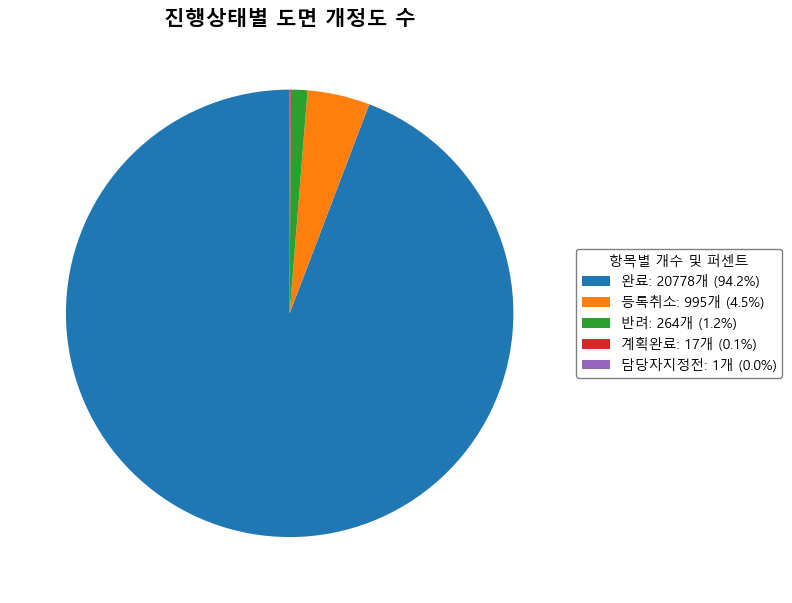

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 진행상태별 도면 개정도 수 계산
status_counts = data_cleaned['진행상태'].value_counts()

# 총 개수 계산
total_count = status_counts.sum()

# 색상 설정
colors = sns.color_palette('tab10')

# 원형 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    status_counts, 
    autopct='',  # 퍼센트 값 자동 표시 비활성화
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 10}
)

# 레이블에 퍼센트 값과 개수 표시
labels_with_pct = [
    f"{label}: {count}개 ({count / total_count * 100:.1f}%)" 
    for label, count in zip(status_counts.index, status_counts)
]

# 레이블을 원형 그래프 바로 우측에 배치
ax.legend(
    wedges, 
    labels_with_pct,
    title="항목별 개수 및 퍼센트",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # 여유 공간을 두고 오른쪽에 배치
    frameon=True,  # 레이블 배경 테두리 제거
    edgecolor='grey',  # 테두리 색상 설정
    framealpha=1,  # 테두리의 투명도 (1: 불투명)
    fancybox=True  # 모서리를 둥글게
)

# 제목을 맨 위 중앙에 배치
plt.title('진행상태별 도면 개정도 수', loc='center', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

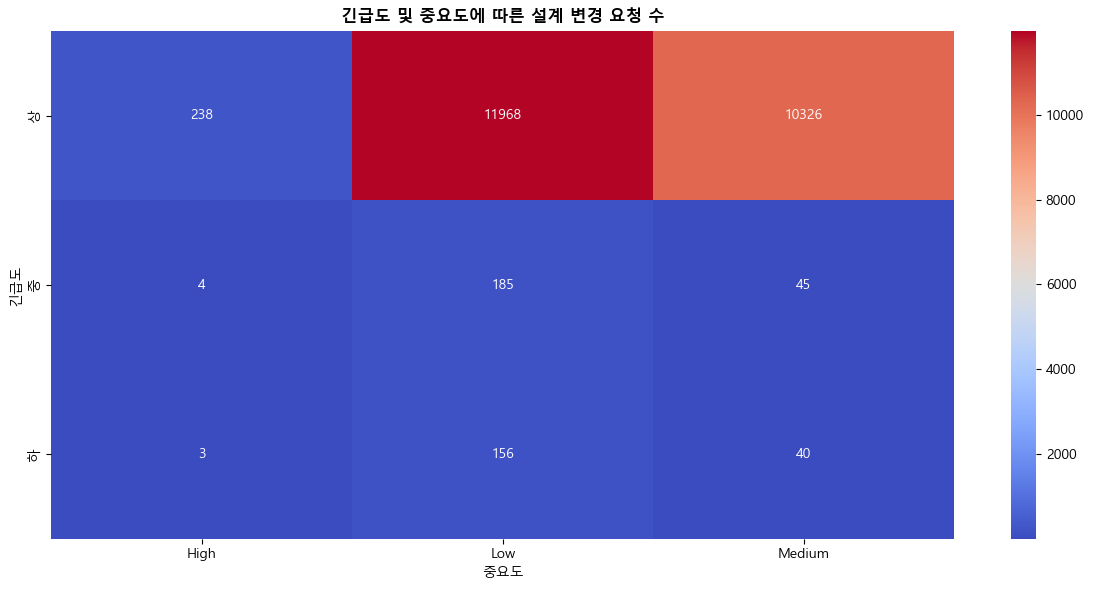

In [9]:
# 긴급도와 중요도별 설계 변경 요청 수 계산
urgency_importance_count = data_cleaned.groupby(['긴급도', '중요도']).size().unstack().fillna(0)

# 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(urgency_importance_count, annot=True, fmt='g', cmap='coolwarm')
plt.title('긴급도 및 중요도에 따른 설계 변경 요청 수', fontweight='bold')
plt.xlabel('중요도')
plt.ylabel('긴급도')
plt.tight_layout()
plt.show()

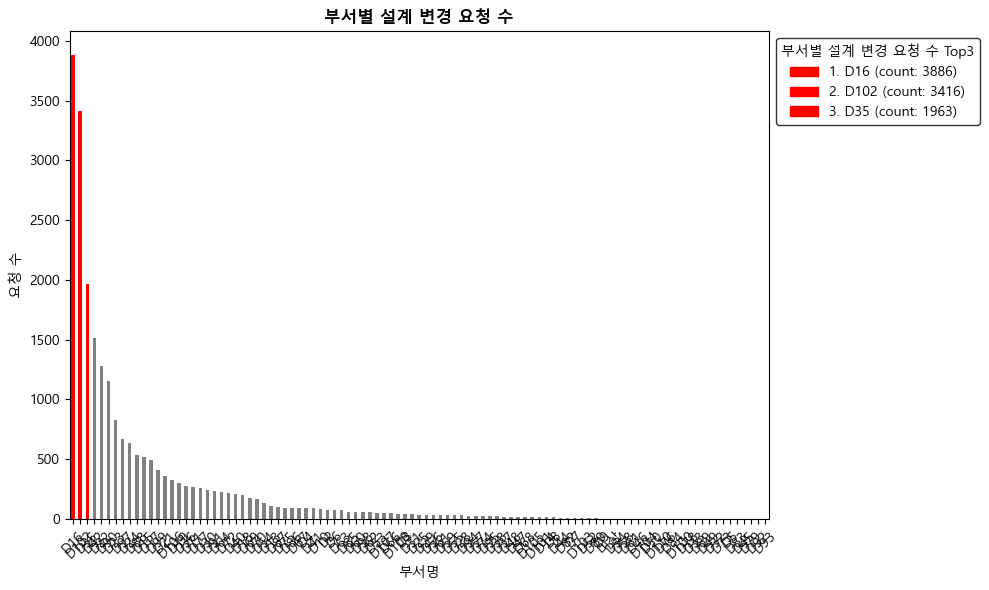

In [10]:
import matplotlib.pyplot as plt

# 부서별 설계 변경 요청 수 계산
department_count = data_cleaned['요청 파트(부서)'].value_counts()

# 시각화 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 색상 설정
colors = ['red' if dept in department_count.nlargest(3).index else 'grey' for dept in department_count.index]

# 그래프 그리기
ax = department_count.plot(kind='bar', color=colors)
plt.title('부서별 설계 변경 요청 수', fontweight='bold')
plt.xlabel('부서명')
plt.ylabel('요청 수')
plt.xticks(rotation=45)

# 상위 3개 항목을 가져와 범례로 표시
top3_departments = department_count.nlargest(3).index.tolist()
top3_counts = department_count.nlargest(3).values.tolist()
legend_labels = [f"{i+1}. {dept} (count: {count})" for i, (dept, count) in enumerate(zip(top3_departments, top3_counts))]

# 범례 추가
legend_title = "부서별 설계 변경 요청 수 Top3"
legend = plt.legend([plt.Rectangle((0,0),1,1,color='red')]*3, legend_labels, title=legend_title,
                    loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
legend.get_frame().set_edgecolor('black')  # 범례 테두리 색상 설정

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_5136\3466171714.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\user\.conda\envs\work\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


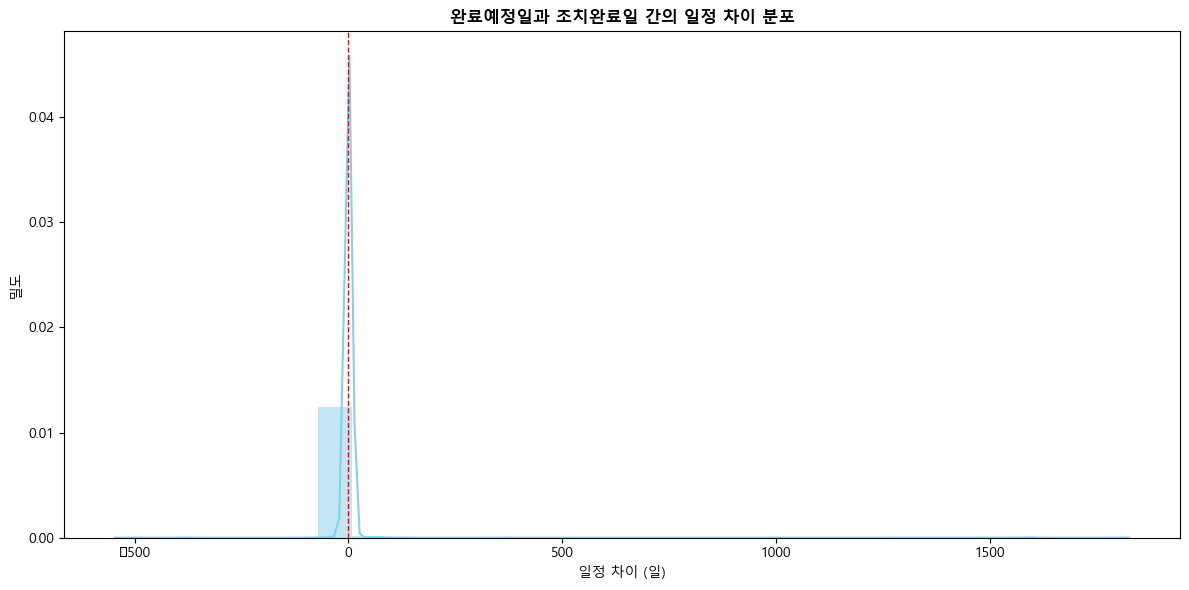

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 완료예정일과 조치완료일의 시간차 계산
data_cleaned['일정차이'] = (data_cleaned['조치완료일'] - data_cleaned['완료예정일']).dt.days

# 히스토그램과 KDE 플롯을 사용하여 일정 차이의 분포 시각화
plt.figure(figsize=(12, 6))

# 히스토그램
# 히스토그램은 일정 차이의 분포를 막대로 표현한 것이며, KDE는 이 분포를 부드럽게 표현한 곡선입니다.
# KDE 곡선이 높아지는 곳에서 많은 데이터가 집중되어 있음을 나타냅니다.
sns.histplot(data=data_cleaned, x='일정차이', bins=30, kde=True, color='skyblue', stat='density', linewidth=0)

# 중앙선을 그려서 차이가 없는 지점을 강조
plt.axvline(0, color='red', linestyle='--', linewidth=1)

# 레이블 및 제목 설정
plt.title('완료예정일과 조치완료일 간의 일정 차이 분포', fontweight='bold')
plt.xlabel('일정 차이 (일)')
plt.ylabel('밀도')
plt.tight_layout()
plt.show()


모델 성능 평가 (MSE): 8172.264227843013


C:\Users\user\AppData\Local\Temp\ipykernel_5136\3771027561.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\user\.conda\envs\work\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


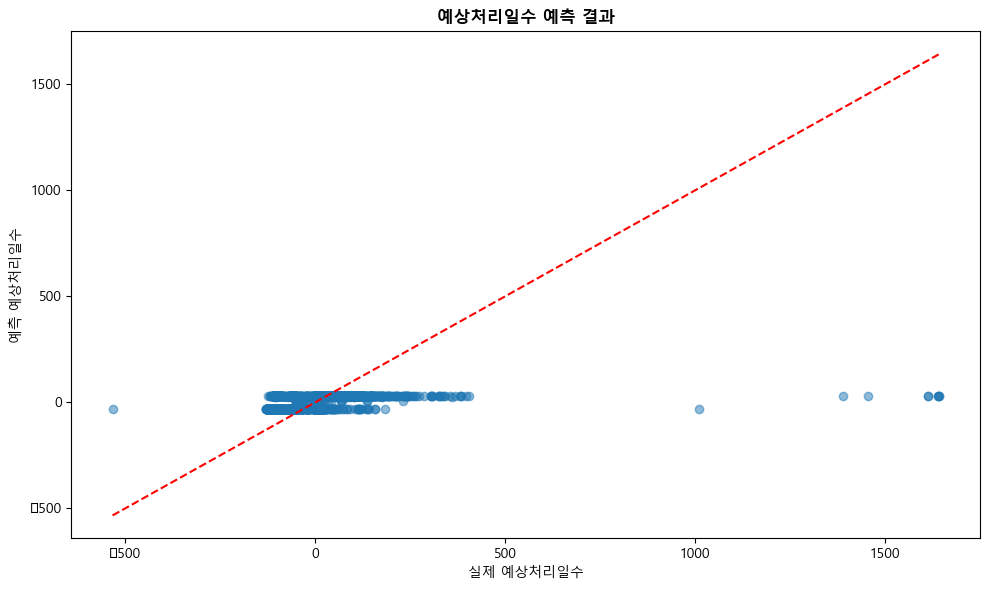

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 완료예정일과 등록일의 차이를 계산하여 예측 변수로 사용
data_cleaned['예상처리일수'] = (data_cleaned['조치완료일'] - data_cleaned['등록일']).dt.days

# 결측치 제거
data_cleaned = data_cleaned.dropna(subset=['예상처리일수'])

# 특성과 타겟 설정 (예시로 '긴급도'와 '중요도'를 특성으로 사용)
features = pd.get_dummies(data_cleaned[['긴급도', '중요도']], drop_first=True)
target = data_cleaned['예상처리일수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"모델 성능 평가 (MSE): {mse}")

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 예상처리일수')
plt.ylabel('예측 예상처리일수')
plt.title('예상처리일수 예측 결과', fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
'''
이 그래프는 실제 예상 처리일수와 예측된 예상 처리일수 간의 관계를 시각화한 산점도입니다. 빨간색 점선은 이상적인 상황에서의 예측을 나타내며, 이 선에 가까울수록 모델이 정확한 예측을 하고 있음을 의미합니다. 다음은 그래프의 해석과 이를 통해 얻을 수 있는 인사이트입니다:

- 그래프 해석:
1. 대부분의 데이터가 점선 아래에 있음: 그래프에서 대부분의 점이 빨간색 점선 아래에 위치하고 있습니다. 이는 모델이 예측한 예상 처리일수가 실제 처리일수보다 적게 예측되고 있음을 의미합니다. 즉, 모델이 처리 일수를 과소평가하고 있을 가능성이 큽니다.

2. 낮은 실제 처리일수 범위에서 데이터 집중: 그래프의 왼쪽 하단에 데이터가 집중되어 있는 것을 볼 수 있습니다. 이는 실제 처리일수가 대부분 낮은 범위에 속하며, 예측도 이 범위 내에서 이루어지고 있음을 시사합니다. 그러나 점선과의 차이가 있어 모델이 이 범위에서도 정확한 예측을 하고 있지 않다는 것을 알 수 있습니다.

3. 높은 처리일수에 대한 예측 오차: 처리일수가 높은 몇몇 데이터 포인트들이 오른쪽에 위치하고 있으며, 이 점들은 대부분 점선과 거리가 있습니다. 이는 처리일수가 높은 경우에 모델의 예측 오차가 크다는 것을 나타냅니다. 즉, 긴 처리일수를 가진 사례에 대해서는 모델의 성능이 떨어집니다.

4. 점들의 분포: 점들이 전반적으로 빨간색 점선 주위에 고르게 분포되지 않았습니다. 이상적인 예측 성능을 보인다면, 점들은 빨간 점선을 중심으로 고르게 분포되어야 합니다. 현재 그래프에서는 점들이 예측값보다 작게 나타나는 경향이 강합니다.

- 인사이트 및 개선 방안:
1. 모델의 전반적인 성능 개선 필요: 대부분의 예측이 실제 값보다 작게 나오고 있으므로, 모델이 전반적으로 처리 일수를 과소평가하고 있습니다. 모델의 성능을 향상시키기 위해 추가적인 특성(feature)을 고려하거나, 다른 예측 모델(예: 비선형 모델) 사용을 고려해야 할 수 있습니다.

2. 고도화된 데이터 전처리 필요: 예측의 정확도를 높이기 위해 더 고도화된 데이터 전처리가 필요할 수 있습니다. 예를 들어, 처리일수에 영향을 미칠 수 있는 추가적인 변수(예: 요청의 복잡성, 부서의 업무량 등)를 추가하는 것도 한 가지 방법입니다.

3. 긴 처리일수에 대한 개선: 긴 처리일수를 가진 데이터에 대해서는 예측 정확도가 매우 낮아 보입니다. 이를 개선하기 위해 긴 처리일수를 가진 사례들을 집중적으로 분석하고, 이러한 사례의 특성을 모델에 반영하도록 노력해야 합니다.

4. 모델 평가 및 선택: 단순 선형 회귀 모델이 현재 데이터의 복잡성을 충분히 반영하지 못할 수 있습니다. 비선형 회귀 모델, 의사결정 나무, 랜덤 포레스트 등 다양한 모델을 시도하여 성능을 비교해 보는 것이 좋습니다.

>> 결론적으로, 이 그래프는 현재 모델이 전반적으로 예상 처리일수를 과소평가하고 있으며, 특히 긴 처리일수의 예측 정확도가 낮음을 시사합니다. 이를 개선하기 위해서는 데이터 전처리와 특성 공학을 통해 모델의 성능을 높이고, 다양한 모델을 시도하는 것이 중요합니다.
'''

'\n이 그래프는 실제 예상 처리일수와 예측된 예상 처리일수 간의 관계를 시각화한 산점도입니다. 빨간색 점선은 이상적인 상황에서의 예측을 나타내며, 이 선에 가까울수록 모델이 정확한 예측을 하고 있음을 의미합니다. 다음은 그래프의 해석과 이를 통해 얻을 수 있는 인사이트입니다:\n\n- 그래프 해석:\n1. 대부분의 데이터가 점선 아래에 있음: 그래프에서 대부분의 점이 빨간색 점선 아래에 위치하고 있습니다. 이는 모델이 예측한 예상 처리일수가 실제 처리일수보다 적게 예측되고 있음을 의미합니다. 즉, 모델이 처리 일수를 과소평가하고 있을 가능성이 큽니다.\n\n2. 낮은 실제 처리일수 범위에서 데이터 집중: 그래프의 왼쪽 하단에 데이터가 집중되어 있는 것을 볼 수 있습니다. 이는 실제 처리일수가 대부분 낮은 범위에 속하며, 예측도 이 범위 내에서 이루어지고 있음을 시사합니다. 그러나 점선과의 차이가 있어 모델이 이 범위에서도 정확한 예측을 하고 있지 않다는 것을 알 수 있습니다.\n\n3. 높은 처리일수에 대한 예측 오차: 처리일수가 높은 몇몇 데이터 포인트들이 오른쪽에 위치하고 있으며, 이 점들은 대부분 점선과 거리가 있습니다. 이는 처리일수가 높은 경우에 모델의 예측 오차가 크다는 것을 나타냅니다. 즉, 긴 처리일수를 가진 사례에 대해서는 모델의 성능이 떨어집니다.\n\n4. 점들의 분포: 점들이 전반적으로 빨간색 점선 주위에 고르게 분포되지 않았습니다. 이상적인 예측 성능을 보인다면, 점들은 빨간 점선을 중심으로 고르게 분포되어야 합니다. 현재 그래프에서는 점들이 예측값보다 작게 나타나는 경향이 강합니다.\n\n- 인사이트 및 개선 방안:\n1. 모델의 전반적인 성능 개선 필요: 대부분의 예측이 실제 값보다 작게 나오고 있으므로, 모델이 전반적으로 처리 일수를 과소평가하고 있습니다. 모델의 성능을 향상시키기 위해 추가적인 특성(feature)을 고려하거나, 다른 예측 모델(예: 비선형 모델) 사용을 고려해야 할 수 있습니다.\n\n2. 고도화된 데이터 전처